## Strong Lensing Time Delay metric

This metric is used to estimate the number of strongly lensed supernovae


## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from lsst.sims.maf.metrics.snSLMetric import SNSLMetric
import lsst.sims.maf.metrics as metrics

## DB file choice

In [2]:
# Database available from https://lsst-web.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.4/baseline/
dbFile = 'baseline_v1.4_10yrs.db' #'descddf_v1.4_10yrs.db'
dbName = 'baseline_v1.4_10yrs.db'
opsimdb = db.OpsimDatabase(dbFile)

## Define slicer

In [3]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make the bundles

### Run for selected years

In [4]:
bundleList= []

metric = SNSLMetric(night_collapse=True)
summaryStats = [metrics.SumMetric()]            
sql = 'night < 730'

bundleList.append(metricBundles.MetricBundle(
    metric, slicer, sql, runName= dbName,summaryMetrics=summaryStats))
print(len(bundleList))

1


In [5]:
%%time
outDir = '{}_SLTimeDelay'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night < 730 for columns ['observationStartMJD', 'filter', 'fieldDec', 'fieldRA', 'night', 'visitTime', 'numExposures', 'visitExposureTime', 'observationId']
Found 419491 visits
Running:  ['baseline_v1_4_10yrs_db_SNSLMetric_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 56.3 s, sys: 2.5 s, total: 58.8 s
Wall time: 50.6 s


Plotting figures with "night < 730" constraint now.
monopole: 0.000357417  dipole: lon: -31.4774, lat: -34.0165, amp: 6.39231e-05
Plotting complete.


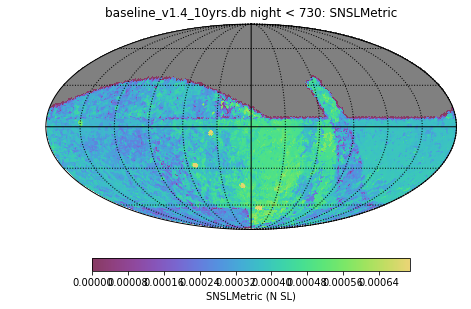

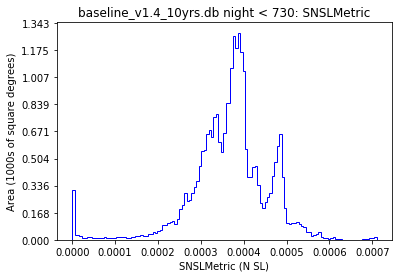

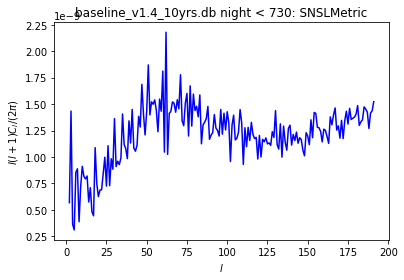

In [6]:
bgroup.plotAll(closefigs=False)

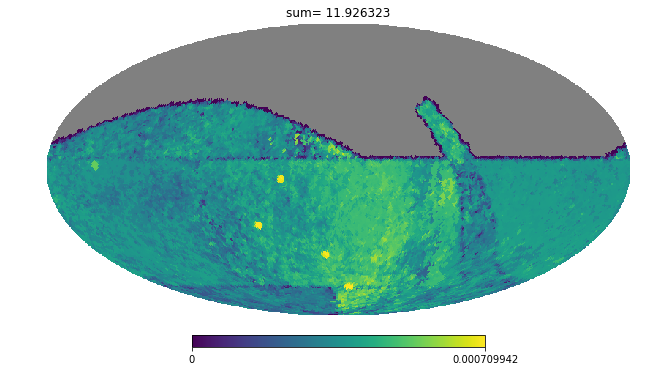

In [7]:
#Now just make the plot manually 
import healpy as hp
hp.mollview(bundleList[0].metricValues,  title='sum= %f' % bundleList[0].summaryValues['Sum'])